# Knowledge Improvement and didactalia activity analysis
In this anaysis, we study the impact of the use of the didactalia resources between pre and post test on the knowledge improvement.

# Imports & Constants

## Fuseki Endpoint : you might want to change it!

In [1]:
FUSEKI_DATASET = "evalafel" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

## Imports, constant settings

In [2]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX sch: <http://schema.org/>
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
def sparql_to_dataframe(query, **kwargs):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio, **kwargs)
    finally:
        del res
        gc.collect()

# Knowledge Increasment Extraction

In [6]:
def get_knowledge_cognitive_tests():
    """
    Retrieve the results of the cognitives pre and post tests in geography and history
    """
    query = SPARQL_PREFIX + """
    SELECT ?userid ?questionID ?ratingValue
    WHERE { 
      $action a sch:ChooseAction .
      $action sch:endTime ?time .
      $action sch:actionOption $rating .
      $rating sch:ratingValue ?ratingValue .
      $action sch:object $question .
      $question sch:identifier ?questionID .
      $question sch:isPartOf $questionnaire .
      $rating sch:author $user .
      $user afl:userName ?userid .
      FILTER regex(?questionID, "^AFEL_2_KNOW") .
    }
    """
    return sparql_to_dataframe(query)

In [7]:
def process_know_stats(df_know_tests):
    '''
    from the results of test, compute two dataframes that provide min, mean& max score
    of knowledge increasing for each user for both geopgraphy and history tests.
    '''
    def process_sub_test_df(sub_df):
        # Compute relative id of questions
        sub_df['questionID'] = sub_df.questionID.str.extract('AFEL_2_KNOW_(?:PRE|POST)_(?:GEO|HIST)_(.*)', expand=False)
        # Compute pivot table to have questionID as columns
        return sub_df.pivot(index='userid', columns='questionID', values='ratingValue')
    # convert userid into simpler int userid
    df_know_tests['userid'] = np.vectorize(int)(df_know_tests.userid.str.extract('project.afel\+(\d+)', expand=False))
    # split test results into four independent dataframes
    df_pre_geo = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_GEO'),:].copy())
    df_pre_hist = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_HIST'),:].copy())
    df_post_geo = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_GEO'),:].copy())
    df_post_hist = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_HIST'),:].copy())
    # Compute differences of scores
    df_diff_geo = df_post_geo - df_pre_geo
    df_diff_hist = df_post_hist - df_pre_hist
    # Remove partial results
    df_diff_geo.dropna(inplace=True)
    df_diff_hist.dropna(inplace=True)
    # Compute min, max and mean score for each user
    df_know_geo_stats = df_diff_geo.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max()}, 
                                  result_type='expand')
    df_know_hist_stats = df_diff_hist.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max()}, 
                                  result_type='expand')
    return df_know_geo_stats, df_know_hist_stats

In [8]:
df_know_geo_stats, df_know_hist_stats = process_know_stats(get_knowledge_cognitive_tests())

# Activities extraction

In [9]:
def get_user_didactalia_activities():
    query = SPARQL_PREFIX + """
    SELECT ?userid ?catQuest ?artId ?actStartTime ?actEndTime
    WHERE {
        $activity a ?activityType .
        $activity afl:user ?user .
        $activity afl:artifact $artifact .
        
        $activity afl:eventStartDate ?actStartTime .
        $activity afl:eventEndDate ?actEndTime .
        $activity sch:location ?location .
        ?user afl:userName ?userid .
        $artifact afl:resourceID ?artId .
        
        FILTER(?activityType IN (afl:ArtifactView, extafl:DidactaliaGamePlayed)) .
        FILTER(?location = "https://didactalia.net") .
        FILTER(?actStartTime >= ?timePre && ?actEndTime <= ?timePost) .
        {
            SELECT ?user ?catQuest (MIN(?timeTest) AS ?timePre) (MAX(?timeTest) AS ?timePost)
            WHERE {
                {
                    SELECT ?user (REPLACE(?questionnaireId, "AFEL_2_KNOW_(PRE|POST)_", "") AS ?catQuest) ?timeTest
                    WHERE {
                        $action a sch:ChooseAction .
                        $action sch:object $question .
                        $question a sch:Question.
                        $question sch:isPartOf $questionnaire .
                        $questionnaire a extafl:Questionnaire .
                        $action sch:agent $user .
                        $user a afl:User .
                        $action sch:endTime ?timeTest .
                        $questionnaire sch:identifier ?questionnaireId .
                        FILTER(REGEX(?questionnaireId, "AFEL_2_KNOW_(PRE|POST)_(HIST|GEO)")) .
                    }
                }
            }
            GROUP BY ?user ?catQuest
        }
    }
    """
    return sparql_to_dataframe(query, parse_dates=[3, 4])

In [10]:
df_activities = get_user_didactalia_activities()

### Convert usernames to ids

In [11]:
df_activities['userid'] = np.vectorize(int)(df_activities.userid.str.extract('project.afel\+(\d+)', expand=False))

### Sort by userid, catQuest and actStartTime

In [12]:
df_activities.sort_values(['userid', 'catQuest', 'actStartTime'], inplace=True)
df_activities.reset_index(drop=True, inplace=True)

### Add shifted userId, catQuest and actStartTime to compute act. duration 

In [13]:
for col in ['userid', 'catQuest', 'actStartTime']:
    df_activities[col + '_next'] = df_activities[col].shift(-1)

In [14]:
# delete last line and reconvert columns in good type
df_activities.drop(df_activities.shape[0] - 1, inplace=True)
df_activities.userid_next = df_activities.userid_next.astype(int)

### Compute duration of activities


In [15]:
df_activities['actTime'] = np.NaN

In [16]:
# If we have the same userId & catQuest for the activity and the next, then we compute the difference 
df_activities.loc[(df_activities.userid == df_activities.userid_next) 
                  & (df_activities.catQuest == df_activities.catQuest_next), 'actTime'] = \
(df_activities.actStartTime_next - df_activities.actStartTime) / np.timedelta64(1,'s')

In [17]:
# If startTime is strictly before endTime, use them to compute length (careful : conversion is done in nanosec)
df_activities.loc[df_activities.actStartTime < df_activities.actEndTime,'actTime'] = \
(df_activities.actEndTime - df_activities.actStartTime) / np.timedelta64(1,'s')

In [18]:
# we drop trace whose length was not able to be computed
df_activities.dropna(inplace=True)

## Compute number of different activity, sum/mean/std length by activity and  sum/mean/std duration by unique activity

### Number of different artifacts consulted

In [19]:
df_nb_artifacts =  df_activities.loc[:,['userid', 'catQuest', 'artId']].drop_duplicates()\
.groupby(['userid', 'catQuest']).count().rename(columns={'artId':'nbArt'})

### Number of activities

In [20]:
df_nb_activities = df_activities.loc[:, ['userid', 'catQuest', 'artId']]\
.groupby(['userid', 'catQuest']).count().rename(columns={'artId':'nbAct'})

### Sum/mean/std duration by activity

In [21]:
df_act_time = df_activities.loc[:,['userid', 'catQuest', 'actTime']]\
.groupby(['userid', 'catQuest']).agg([np.sum, np.mean, np.std])\
.rename(columns={'sum':'actTimeSum', 'mean':'actTimeMean', 'std':'actTimeStd'})

### Sum/mean/std duration by artifact

In [22]:
df_artifact_duration = df_activities.loc[:,['userid', 'catQuest', 'artId', 'actTime']]\
.groupby(['userid', 'catQuest', 'artId']).sum()\
.groupby(['userid', 'catQuest']).agg([np.sum, np.mean, np.std])\
.rename(columns={'sum':'artTimeSum', 'mean':'artTimeMean', 'std':'artTimeStd'})

## Merge all features

In [23]:
# Start droping levels on multiindex columns
df_act_time.columns = df_act_time.columns.droplevel()
df_artifact_duration.columns = df_artifact_duration.columns.droplevel()

In [24]:
df_features = pd.merge(df_nb_artifacts, df_nb_activities, on=['userid', 'catQuest'], validate='one_to_one')

In [25]:
df_features = pd.merge(df_features, df_act_time, on=['userid', 'catQuest'], validate='one_to_one')

In [26]:
df_features = pd.merge(df_features, df_artifact_duration, on=['userid', 'catQuest'], validate='one_to_one')

# Merge Features and test score

### Merge score and features for each category

In [27]:
df_all_geo = pd.merge(df_know_geo_stats, df_features.xs('GEO', level=1), on="userid", validate='one_to_one')

In [28]:
df_all_hist = pd.merge(df_know_hist_stats, df_features.xs('HIST', level=1), on="userid", validate='one_to_one')

### drop indexes, concatenate arrays

In [29]:
df_all = pd.concat([df_all_geo.reset_index(drop=True), df_all_hist.reset_index(drop=True)])

In [30]:
df_all.shape[0] == df_all_geo.shape[0] + df_all_hist.shape[0]

True

# Distribution analysis

In [31]:
df_all.columns

Index(['maxKnow', 'meanKnow', 'minKnow', 'nbArt', 'nbAct', 'actTimeSum',
       'actTimeMean', 'actTimeStd', 'artTimeSum', 'artTimeMean', 'artTimeStd'],
      dtype='object')

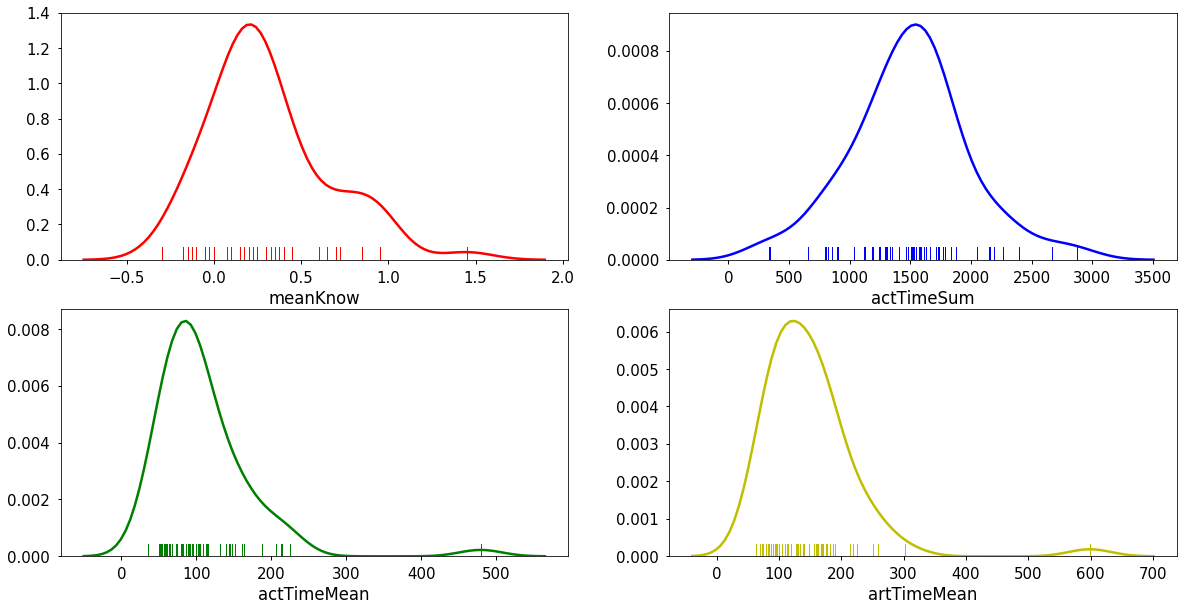

In [32]:
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(df_all.meanKnow, hist=False, rug=True, color="r", ax=axes[0,0])
sns.distplot(df_all.actTimeSum, hist=False, rug=True, color="b", ax=axes[0,1])
sns.distplot(df_all.actTimeMean, hist=False, rug=True, color="g", ax=axes[1,0])
sns.distplot(df_all.artTimeMean, hist=False, rug=True, color="y", ax=axes[1,1])

# Correlation analysis

## pairwise relationships between features

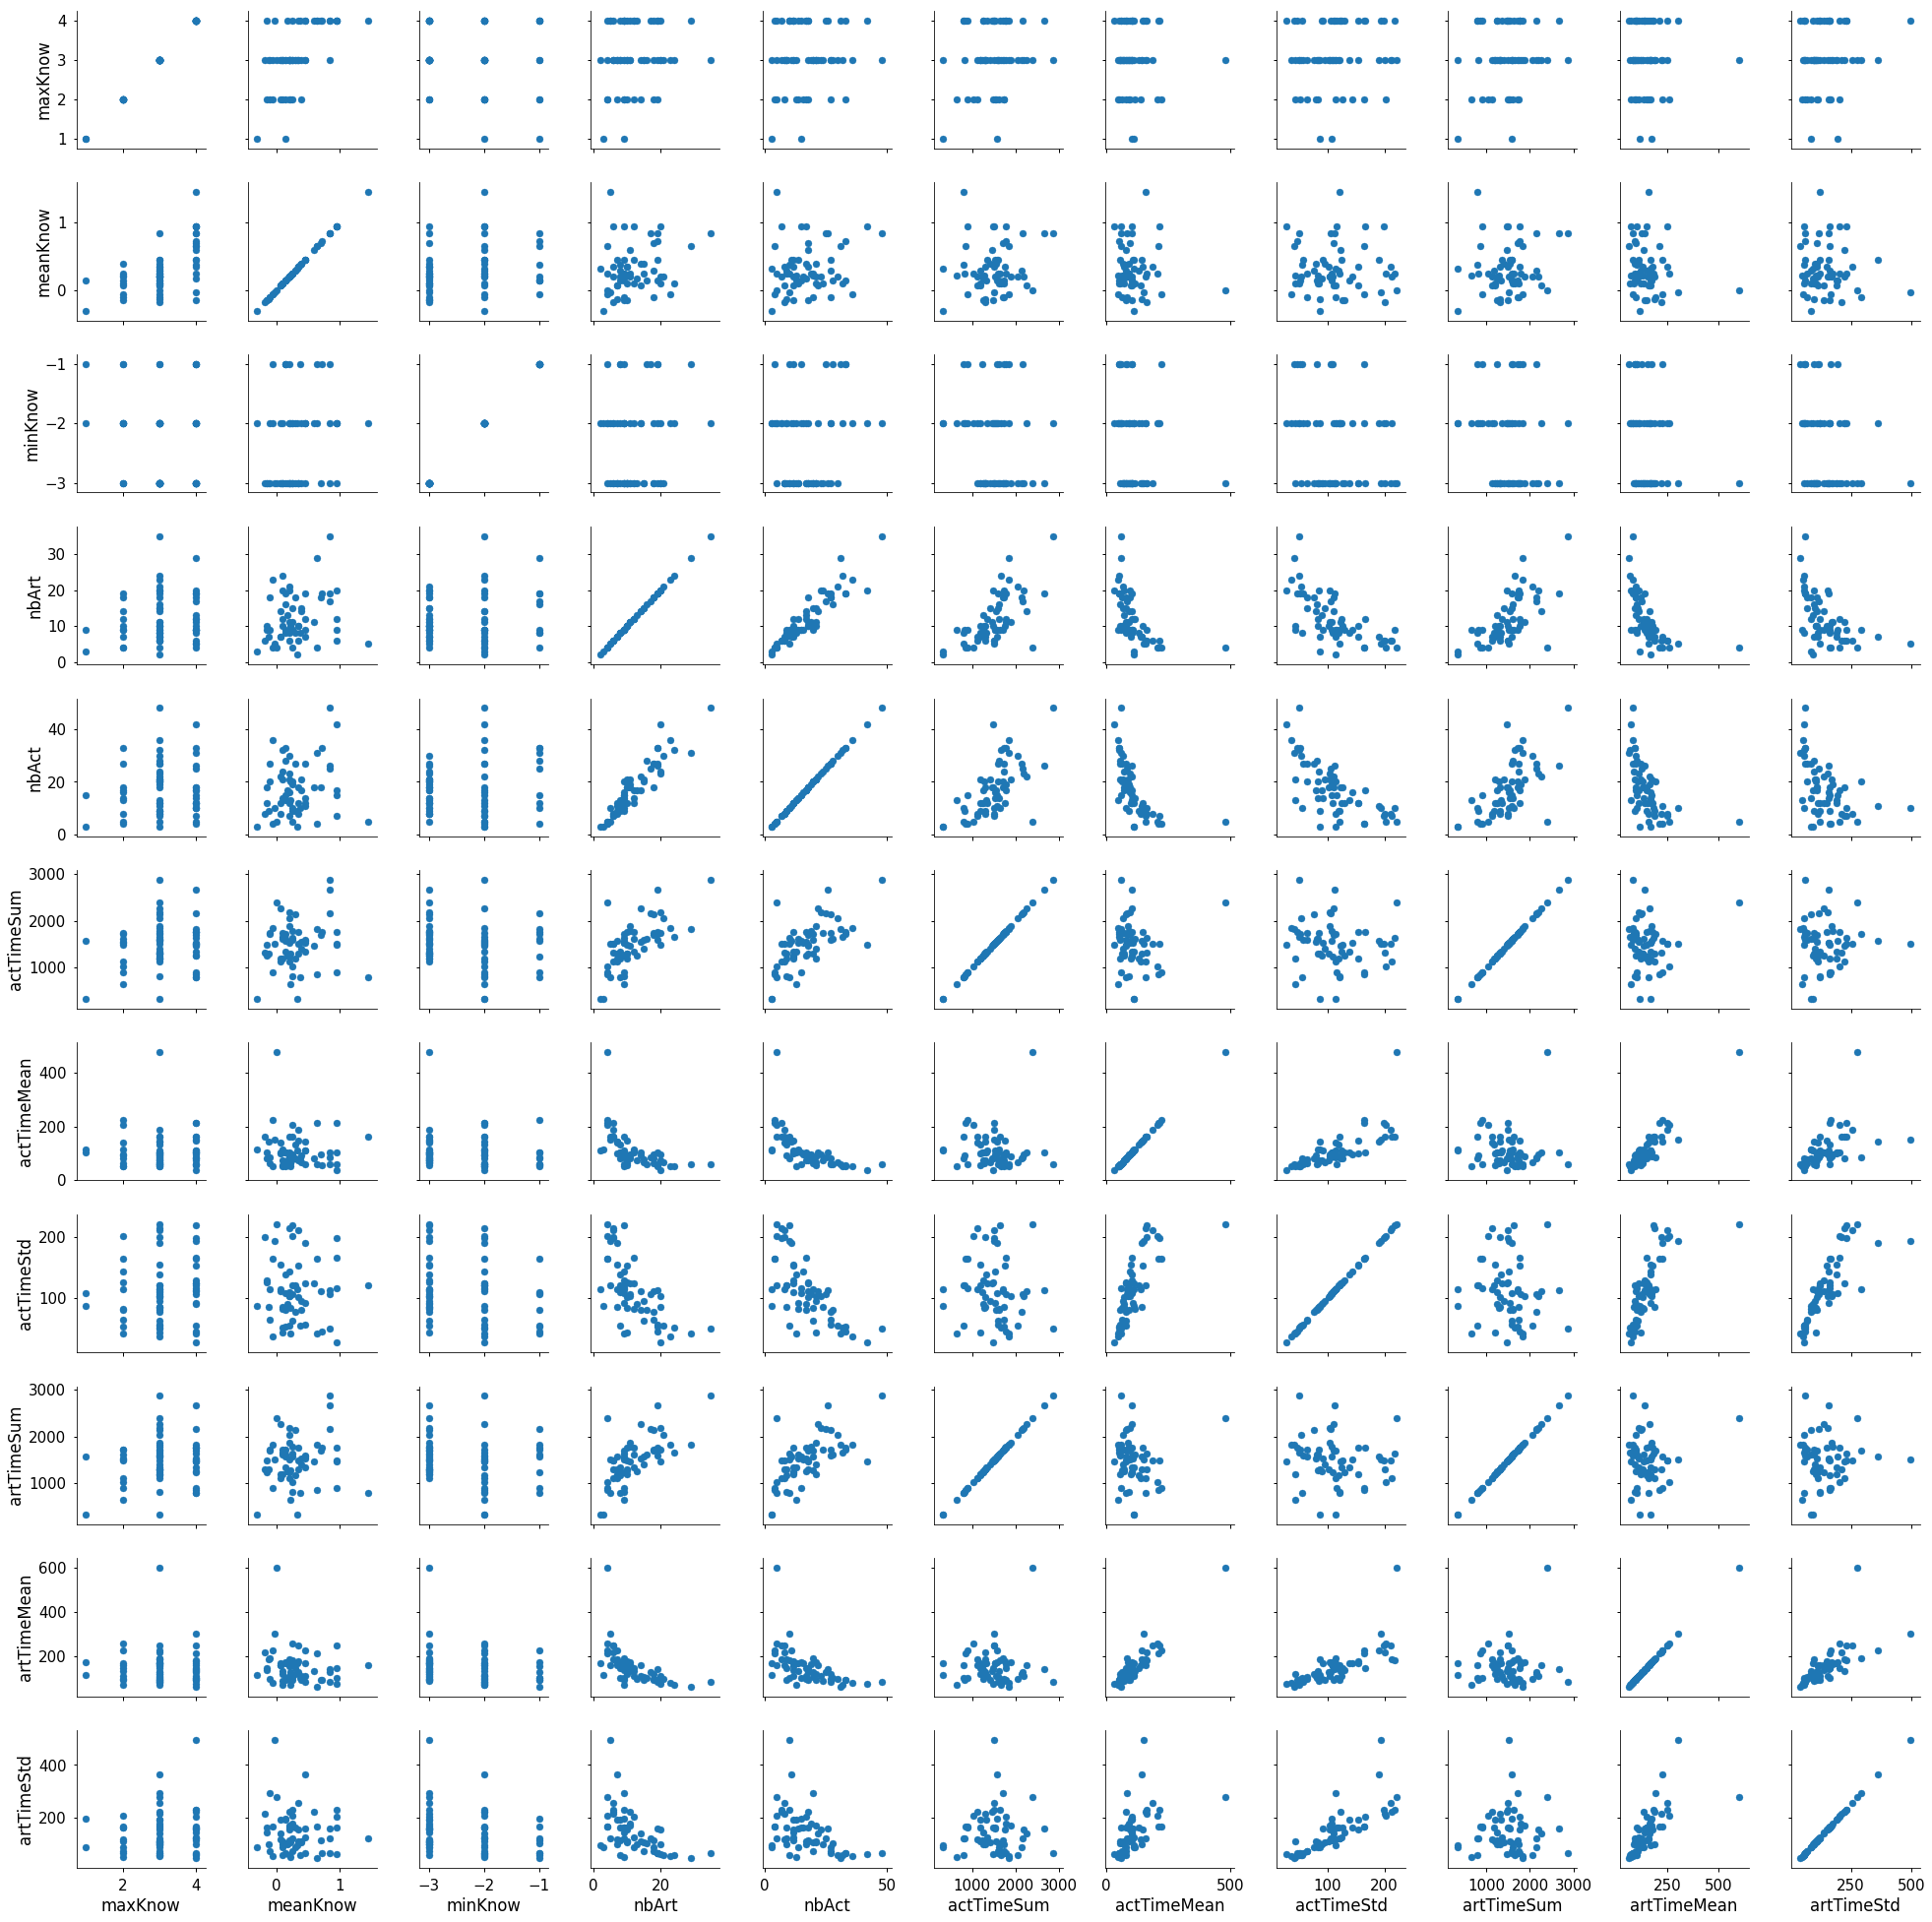

In [33]:
g = sns.PairGrid(df_all)
g = g.map(plt.scatter)

## Correlation between knowledge and features

In [34]:
df_all.columns

Index(['maxKnow', 'meanKnow', 'minKnow', 'nbArt', 'nbAct', 'actTimeSum',
       'actTimeMean', 'actTimeStd', 'artTimeSum', 'artTimeMean', 'artTimeStd'],
      dtype='object')

In [35]:
for indepvar in ['nbArt', 'nbAct', 'actTimeSum', 'actTimeMean', 'actTimeStd', 
                'artTimeSum', 'artTimeMean', 'artTimeStd']:
    print("Test on %s with knowledge" % indepvar)
    for depvar in ['minKnow', 'meanKnow', 'maxKnow']:
        r, pval = pearsonr(df_all[depvar], df_all[indepvar])
        indicator = '***' if pval < .05 else ''
        print("   %s: r = %.3f p-value = %.3f %s" % (depvar, r, pval, indicator))

Test on nbArt with knowledge
   minKnow: r = 0.133 p-value = 0.301 
   meanKnow: r = 0.226 p-value = 0.077 
   maxKnow: r = 0.134 p-value = 0.300 
Test on nbAct with knowledge
   minKnow: r = 0.137 p-value = 0.288 
   meanKnow: r = 0.185 p-value = 0.150 
   maxKnow: r = 0.091 p-value = 0.481 
Test on actTimeSum with knowledge
   minKnow: r = -0.168 p-value = 0.191 
   meanKnow: r = 0.129 p-value = 0.316 
   maxKnow: r = 0.167 p-value = 0.196 
Test on actTimeMean with knowledge
   minKnow: r = -0.129 p-value = 0.318 
   meanKnow: r = -0.085 p-value = 0.512 
   maxKnow: r = -0.003 p-value = 0.984 
Test on actTimeStd with knowledge
   minKnow: r = -0.227 p-value = 0.076 
   meanKnow: r = -0.046 p-value = 0.722 
   maxKnow: r = 0.104 p-value = 0.420 
Test on artTimeSum with knowledge
   minKnow: r = -0.168 p-value = 0.191 
   meanKnow: r = 0.129 p-value = 0.316 
   maxKnow: r = 0.167 p-value = 0.196 
Test on artTimeMean with knowledge
   minKnow: r = -0.209 p-value = 0.104 
   meanKnow: r 

## Test of multiple features regression on mean knowledge increase

In [36]:
lr = LinearRegression() 

In [37]:
X = df_all.loc[:, ['nbArt', 'actTimeSum', 'actTimeMean','actTimeStd', 'artTimeSum', 
                              'artTimeMean', 'artTimeStd']].values

In [38]:
Y = df_all.loc[:, 'meanKnow'].values

In [39]:
lr.fit(X, Y)

/Users/venant/DEVELOPPEMENT/COURANT/Galway/AFEL_Evaluation2/venv/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
lr.score(X, Y)

0.13654500126987046

# Conclusion

It appears that none of the number of resources viewed, the total duration of activity, the mean/std duration by activty of the mean/std duration by resource viewed seem to be correlated with knowledge improvement.